In [1]:
from os import environ
environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/home/valsp/miniconda3/envs/tf/lib"


In [2]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import one_hot
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import KLDivergence
from sklearn import metrics
from model_helper import *
from pathlib import Path

# autoreload
%load_ext autoreload
%autoreload 2


## 1. Load in dataset

In [3]:
cwd = Path().cwd()

In [4]:
with open(cwd.parent / "preprocessing/new_data/training_seq_n_12_rmrp0", "rb") as f:
    train_data = pickle.load(f)
with open(cwd.parent / "preprocessing/new_data/dev_seq_n_12_rmrp0", "rb") as f:
    val_data = pickle.load(f)
with open(cwd.parent / "preprocessing/new_data/test_seq_n_12_rmrp0", "rb") as f:
    test_data = pickle.load(f)

In [5]:
X_train = np.array(train_data["X"])
print(f"X_train shape: {X_train.shape}")
Y_train = np.array(train_data["Y"]).reshape(-1, 1)
print(f"Y_train shape: {Y_train.shape}")
X_val = np.array(val_data["X"])
print(f"X_val shape: {X_val.shape}")
Y_val = np.array(val_data["Y"]).reshape(-1, 1)
print(f"Y_val shape: {Y_val.shape}")
X_test = np.array(test_data["X"])
print(f"X_test shape: {X_test.shape}")
Y_test = np.array(test_data["Y"]).reshape(-1, 1)
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (42598, 12, 22)
Y_train shape: (42598, 1)
X_val shape: (3000, 12, 22)
Y_val shape: (3000, 1)
X_test shape: (3000, 12, 22)
Y_test shape: (3000, 1)


## Load Model

In [6]:
def one_off_accuracy(y_true, y_pred):
    """Computes the accuracy of a grade prediction including +/-1 errors

    Args:
        y_true: true grades
        y_pred: predicted grades
    """
    return tf.reduce_mean(tf.cast(abs(y_true - tf.math.round(y_pred)) <= 1, tf.float32))


In [7]:
GradeNet = load_model("GradeNet", custom_objects={"one_off_accuracy": one_off_accuracy})

2023-12-19 22:35:12.721999: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-19 22:35:12.895973: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-19 22:35:12.906763: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-19 22:35:13.028553: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-19 22:35:13.512753: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _ou

## 3. Analyze GradeNet Performance

### Confusion Matrix

In [8]:
# TODO: are these actually the metrics documented in their paper? why are they so shit

In [9]:
REGRESSION = True

In [10]:
Y_train_prob = GradeNet.predict(X_train)
Y_val_prob = GradeNet.predict(X_val)
Y_test_prob = GradeNet.predict(X_test)


W0000 00:00:1703043321.561050       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2000 num_cores: 8 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 524288 l3_cache_size: 6291456 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


94/94 [==============================] - 1s 5ms/step


In [11]:
if not REGRESSION:
    Y_train_pred = Y_train_prob.argmax(axis=1)
    Y_val_pred = Y_val_prob.argmax(axis=1)
    Y_test_pred = Y_test_prob.argmax(axis=1)
else:
    Y_train_pred = np.around(Y_train_prob, 0)
    Y_val_pred = np.around(Y_val_prob, 0)
    Y_test_pred = np.around(Y_test_prob, 0)



In [12]:
Y_test_pred

array([[0.],
       [0.],
       [2.],
       ...,
       [1.],
       [0.],
       [5.]], dtype=float32)

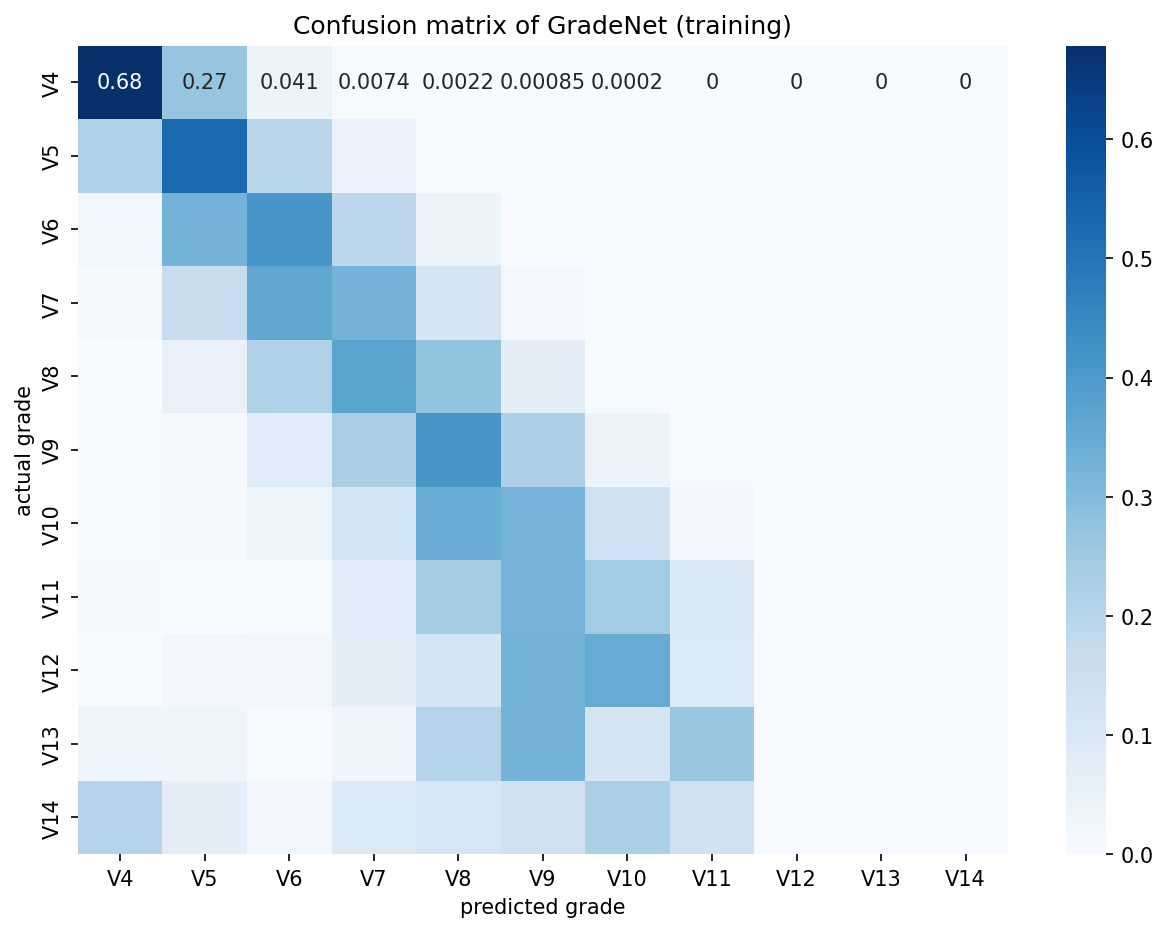

In [13]:
plot_confusion_matrix(Y_train, Y_train_pred, title = 'Confusion matrix of GradeNet (training)')

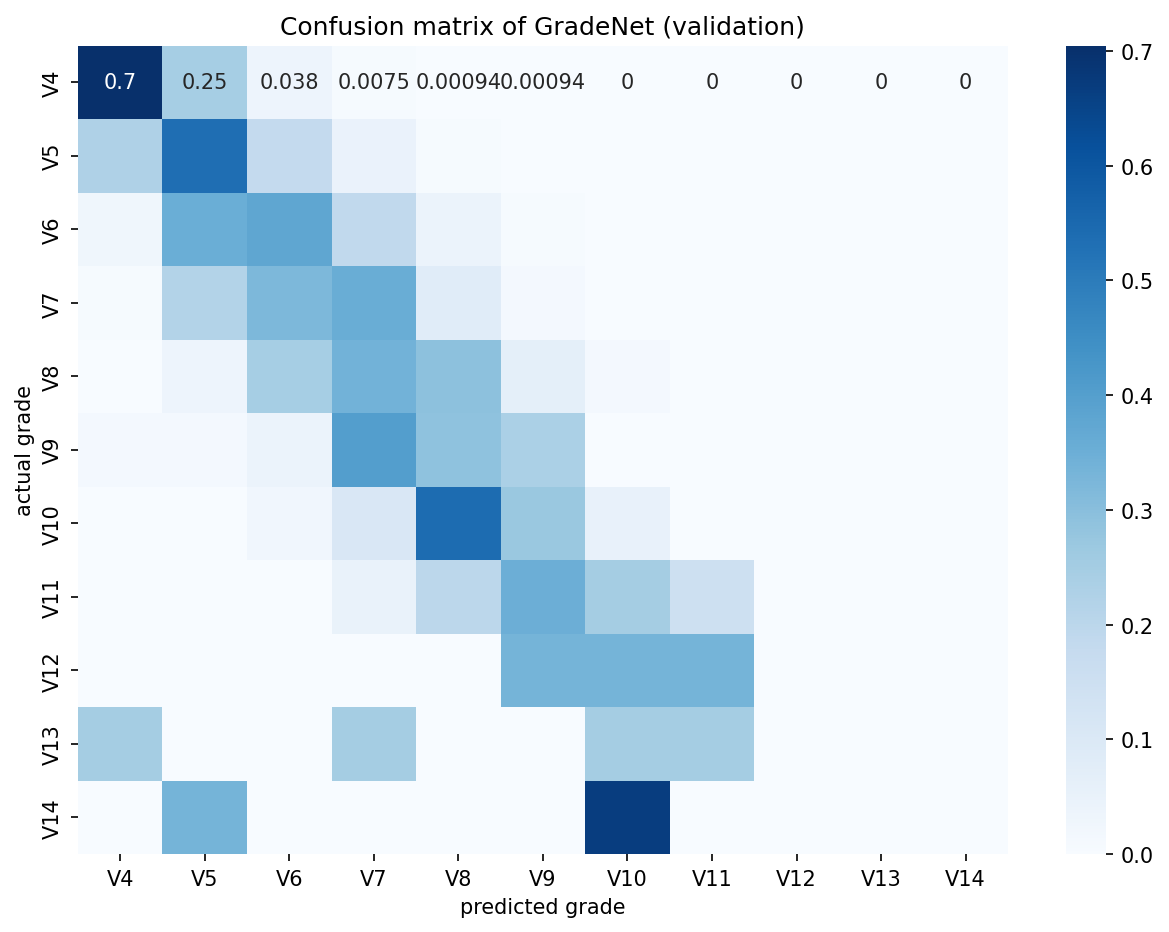

In [14]:
plot_confusion_matrix(Y_val, Y_val_pred, title = 'Confusion matrix of GradeNet (validation)')

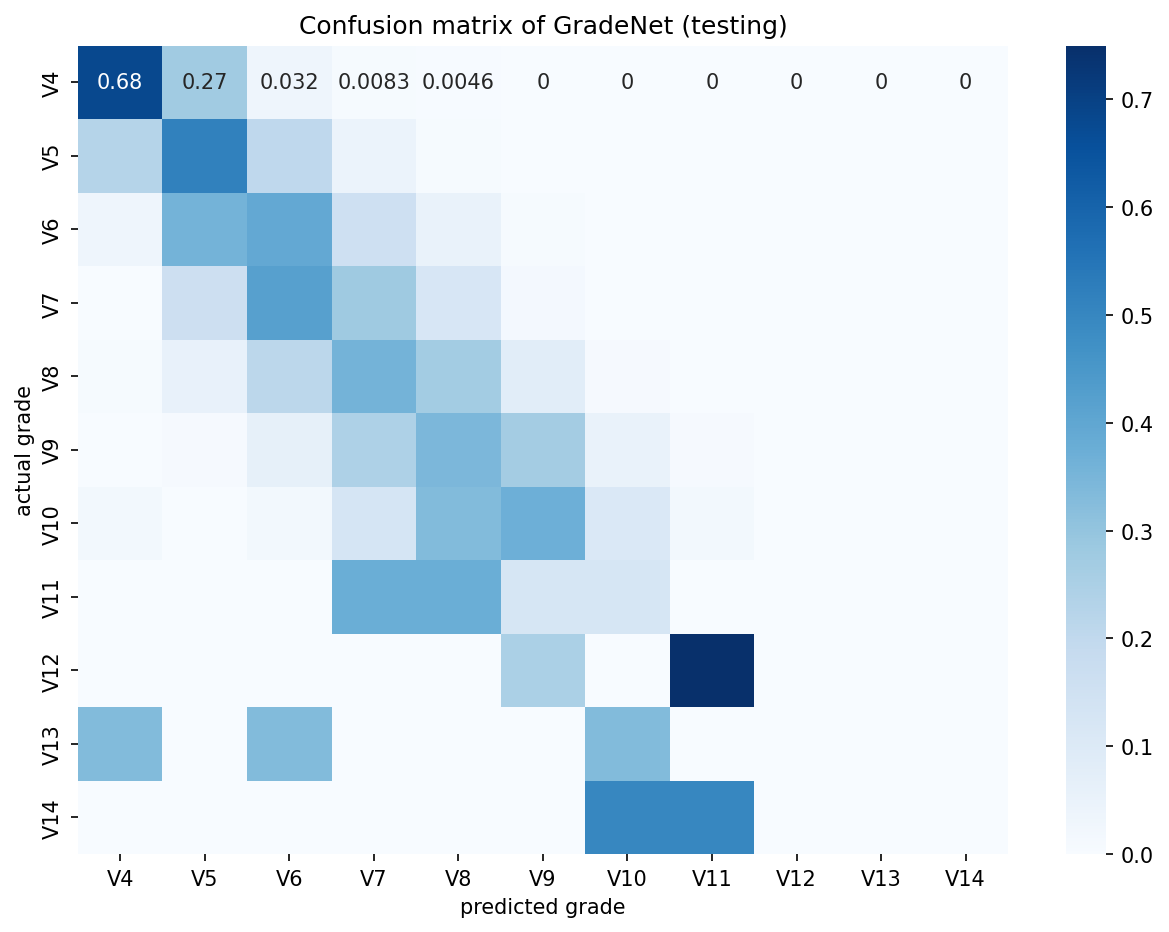

In [15]:
plot_confusion_matrix(Y_test, Y_test_pred, title = 'Confusion matrix of GradeNet (testing)')

### F1 score

In [16]:
F1_train = metrics.f1_score(Y_train, Y_train_pred, average = 'macro')
print(F1_train)

0.2541509736622576


In [17]:
F1_dev = metrics.f1_score(Y_val, Y_val_pred, average = 'macro')
print(F1_dev)

0.25565288546247233


In [18]:
F1_test = metrics.f1_score(Y_test, Y_test_pred, average = 'macro')
print(F1_test)

0.23509206023897206


### Accuracy and Rough accuracy

In [19]:
accuracy_train = compute_accuracy(Y_train, Y_train_pred)
print("Exactly accuracy rate of training set = %s" %accuracy_train[0])
print("+/-1 Accuracy rate of training set= %s" %accuracy_train[1])

Exactly accuracy rate of training set = 0.5095074886144889
+/-1 Accuracy rate of training set= 0.8933518005540166


In [20]:
accuracy_val = compute_accuracy(Y_val, Y_val_pred)
print("Exactly accuracy rate of dev set = %s" %accuracy_val[0])
print("+/-1 Accuracy rate of dev set = %s" %accuracy_val[1])

Exactly accuracy rate of dev set = 0.5213333333333333
+/-1 Accuracy rate of dev set = 0.882


In [21]:
accuracy_test = compute_accuracy(Y_test, Y_test_pred)
print("Exactly accuracy rate of test set = %s" %accuracy_test[0])
print("+/-1 Accuracy rate of test set = %s" %accuracy_test[1])

Exactly accuracy rate of test set = 0.49766666666666665
+/-1 Accuracy rate of test set = 0.8916666666666667


### RMSE

In [22]:
# 
rmse_train = np.sqrt(np.mean((Y_train-Y_train_pred)**2))
print(rmse_train)

rmse_val = np.sqrt(np.mean((Y_val-Y_val_pred)**2))
print(rmse_val)

rmse_test = np.sqrt(np.mean((Y_test-Y_test_pred)**2))
print(rmse_test)

0.9934878810871977
1.003327796219494
1.0086294331087773


### Classification report

In [23]:
sk_report_train = metrics.classification_report(
    digits=4,
    y_true=Y_train, 
    y_pred=Y_train_pred)
print(sk_report_train)

sk_report_val = metrics.classification_report(
    digits=4,
    y_true=Y_val, 
    y_pred=Y_val_pred)
print(sk_report_val)

sk_report_test = metrics.classification_report(
    digits=4,
    y_true=Y_test, 
    y_pred=Y_test_pred)
print(sk_report_test)

              precision    recall  f1-score   support

         0.0     0.7816    0.6787    0.7265     15210
         1.0     0.4937    0.5299    0.5112     12290
         2.0     0.2912    0.4119    0.3412      5382
         3.0     0.2533    0.3248    0.2846      3704
         4.0     0.4120    0.2757    0.3304      3888
         5.0     0.2991    0.2249    0.2568      1245
         6.0     0.3099    0.1394    0.1923       538
         7.0     0.3818    0.0955    0.1527       220
         8.0     0.0000    0.0000    0.0000        43
         9.0     0.0000    0.0000    0.0000        34
        10.0     0.0000    0.0000    0.0000        44

    accuracy                         0.5095     42598
   macro avg     0.2930    0.2437    0.2542     42598
weighted avg     0.5326    0.5095    0.5156     42598

              precision    recall  f1-score   support

         0.0     0.7761    0.7048    0.7387      1067
         1.0     0.5064    0.5359    0.5207       892
         2.0     0.2877 

/usr/local/Caskroom/miniconda/base/envs/cs137/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniconda/base/envs/cs137/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniconda/base/envs/cs137/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [24]:
if not REGRESSION:
    AUC_train = metrics.roc_auc_score(Y_train, Y_train_prob, multi_class= 'ovr', average="macro")
    print(AUC_train)

    AUC_val = metrics.roc_auc_score(Y_val, Y_val_prob, multi_class= 'ovr', average="macro")
    print(AUC_val)

    AUC_test = metrics.roc_auc_score(Y_test, Y_test_prob, multi_class= 'ovr', average="macro")
    print(AUC_test)